In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

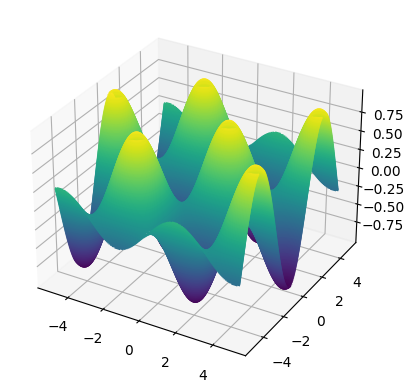

In [2]:
num_of_samples = 150
x_data = np.float64(np.linspace(-5, 5, num_of_samples))
y_data = np.float64(np.linspace(-5, 5, num_of_samples))

X, Y = np.meshgrid(x_data, y_data)
Z = np.sin(X)*np.cos(Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 200)
plt.show()

In [3]:
dataset = Dataset(np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1), Z.reshape(-1, 1))
trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

activation = nn.Sigmoid()

In [4]:
class ELM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = activation(x)
        x = self.fc2(x)
        return x

model = ELM(2, 100, 1)

In [5]:
for i, (x, y) in enumerate(trainloader):
    V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ x.T)
    H = torch.concatenate([torch.ones(1, len(x)), V], dim=0).T
    T = y.reshape(1, -1).T
    if i == 0:
        # W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
        P = torch.linalg.inv(H.T @ H + 1e-8*torch.eye(H.shape[1]))
        W2 = P @ H.T @ T.reshape(1, -1, 1)
    else:
        P = P - P @ H.T @ torch.linalg.inv(torch.eye(H.shape[0]) + H @ P @ H.T) @ H @ P
        W2 = W2 + P @ H.T @ (T.reshape(1, -1, 1) - H @ W2)
model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

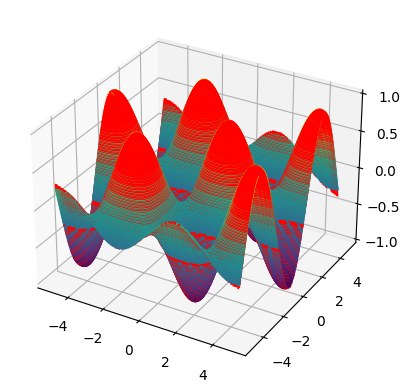

Train error: 4.472535767061997e-05
Test error: 4.8305418715030976e-05


In [6]:
X, Y = np.meshgrid(x_data, y_data)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1)).detach().numpy().reshape(num_of_samples, num_of_samples), 200, colors='red')
ax.contour3D(X, Y, Z, 200)
plt.show()
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 2))-trainset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 2))-testset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')

In [7]:
import plotly.graph_objects as go

predictions = model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1)).detach().numpy().reshape(-1)
trace1 = go.Scatter3d(
    x=X.reshape(-1),
    y=Y.reshape(-1),
    z=Z.reshape(-1) - predictions,
    mode='markers',
    marker=dict(
        size=2,
        color=Z.reshape(-1) - predictions,
        colorscale='Viridis',
        colorbar=dict(title='Data - predicitions'),
    ),
    name='Model'
)
fig = go.Figure(data=[trace1], layout=dict(width=700, height=500))
fig.show()

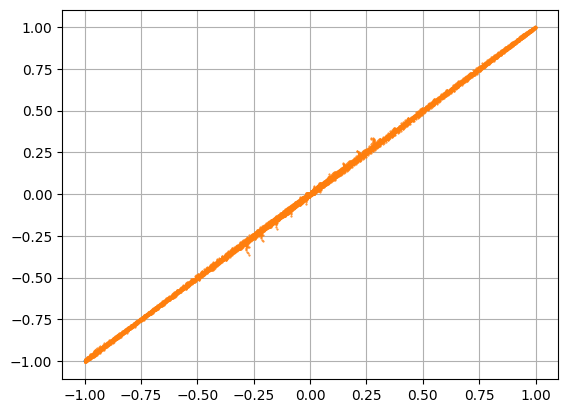

In [8]:
plt.plot([np.min(Z), np.max(Z)], [np.min(Z), np.max(Z)])
plt.plot(Z.reshape(-1), model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1)).detach().numpy().reshape(-1), '.', markersize=1)
plt.grid()
plt.show()